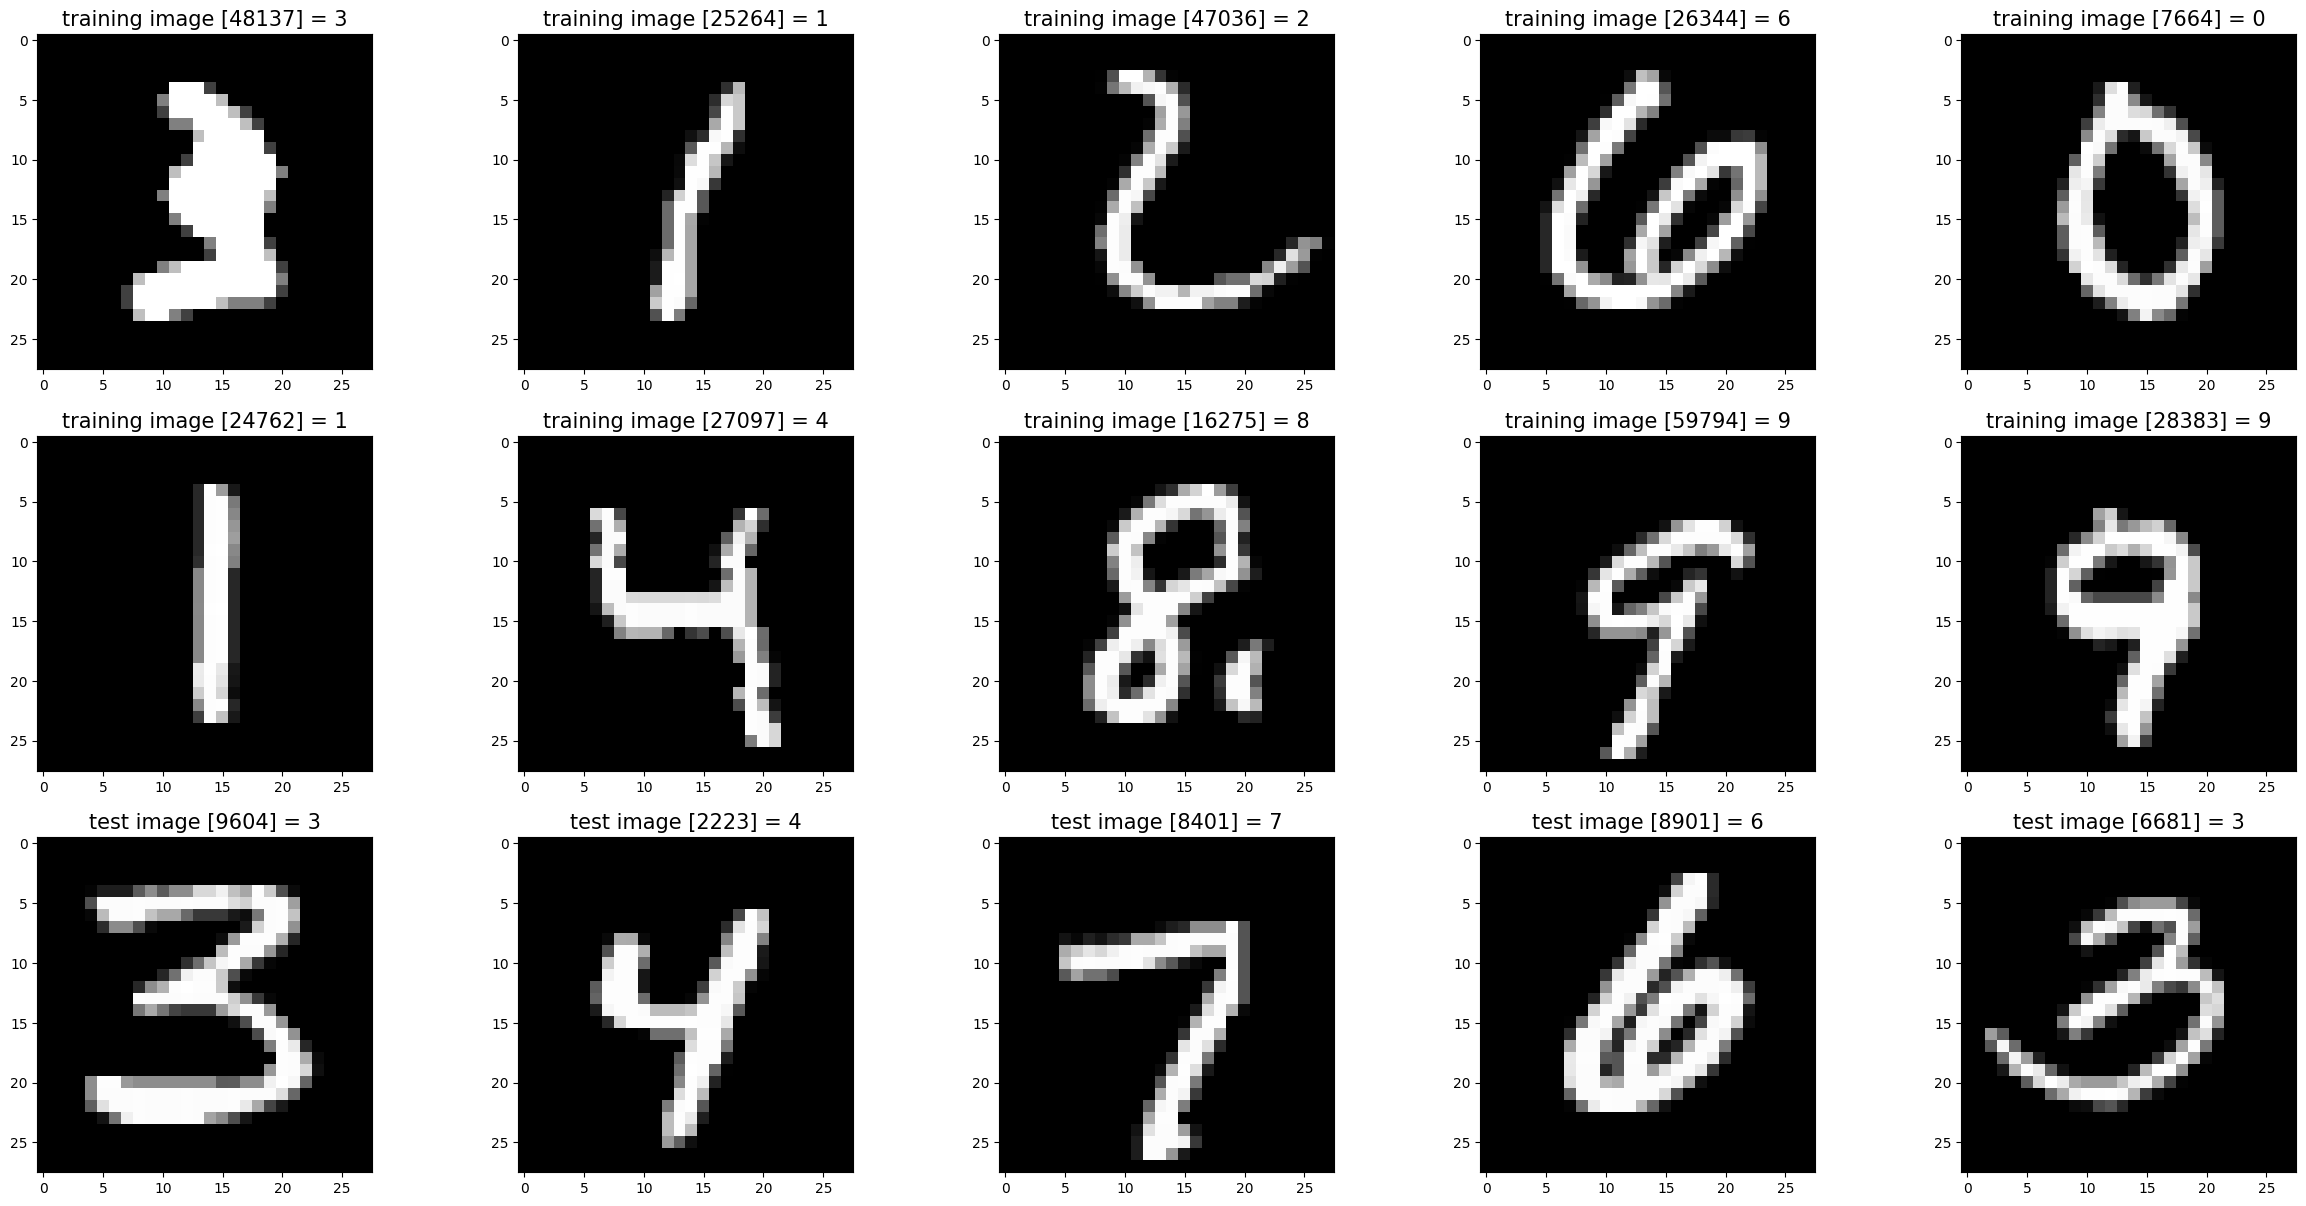

In [1]:
import random
import matplotlib.pyplot as plt 
import numpy as np
import struct
from array import array
from os.path import join
import time
from numpy import typing as npt

class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1
    plt.show()

input_path = './'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [2]:
# Преобразование в numpy массивы и нормализация
x_train = np.array(x_train, dtype=np.float32) / 255.0
x_test = np.array(x_test, dtype=np.float32) / 255.0

# Изменение формы данных: из (60000, 28, 28) в (60000, 784)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

y_train = np.eye(10, dtype=np.float32)[y_train]
y_test = np.eye(10, dtype=np.float32)[y_test]

class DeepNeuralNetwork():
    def __init__(
            self,
            sizes: list[int],
            epochs: int=20,
            batch_size:int=64,
            l_rate: float=0.01,
        ):
        self.sizes = sizes
        self.epochs = epochs
        self.batch_size = batch_size
        self.l_rate = l_rate

        self.params = self.initialization()

    def ReLU(
            self,
            x: npt.NDArray[np.float32],
            derivative: bool=False
    ) -> np.ndarray:

        if derivative:
            return x > 0
        return np.maximum(x, 0)

    # Стабильный softmax
    def softmax(
            self,
            x: npt.NDArray[np.float32],
            axis: int=-1,
    ) -> npt.NDArray[np.float32]:

        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=axis, keepdims=True)

    # Инициальзация параметров слоёв
    def initialization(self) -> dict[str, npt.NDArray[np.float32]]:

        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        output_layer=self.sizes[2]

        params = {
            'W1':np.random.randn(input_layer, hidden_1) * np.sqrt(1. / hidden_1),
            'b1': np.random.randn(1, hidden_1) * np.sqrt(1. / hidden_1),

            'W2':np.random.randn(hidden_1, output_layer) * np.sqrt(1. / output_layer),
            'b2': np.random.randn(1, output_layer) * np.sqrt(1. / hidden_1),
        }

        return params

    def forward_pass(
            self,
            x_train: npt.NDArray[np.float32],
    ) -> npt.NDArray[np.float32]:

        self.params['A0'] = x_train

        self.params['Z1'] = self.params['A0'] @ self.params["W1"]  + self.params['b1']
        self.params['A1'] = self.ReLU(self.params['Z1'])

        self.params['Z2'] = self.params['A1'] @ self.params["W2"]  + self.params['b2']
        self.params['A2'] = self.softmax(self.params['Z2'])

        return self.params['A2']

    def backward_pass(
            self,
            y_train: npt.NDArray[np.float32],
            output: npt.NDArray[np.float32],
    ) -> dict[str, npt.NDArray[np.float32]]:

        change_w = {}

        # градиент на выходе
        dZ2 = (output - y_train)

        change_w['W2'] = (self.params['A1'].T) @ dZ2  * 1 / y_train.shape[0]
        change_w['b2'] =  np.sum(dZ2, axis=0, keepdims=True) * 1 / y_train.shape[0]

        dZ1 = 1 / y_train.shape[0] * dZ2 @ self.params['W2'].T * self.ReLU(self.params['Z1'], derivative=True)

        change_w['W1'] = self.params['A0'].T @ (dZ1)
        change_w['b1'] =  np.sum(dZ1, axis=0, keepdims=True)

        return change_w

    # Обновляем параметры используя градиентный спуск
    def update_params(self, change_w: dict[str, npt.NDArray[np.float32]]) -> None:

        self.params["W1"] -= self.l_rate * change_w['W1']
        self.params["W2"] -= self.l_rate * change_w['W2']
        self.params["b1"] -= self.l_rate * change_w['b1']
        self.params["b2"] -= self.l_rate * change_w['b2']

    def get_accuracy(
            self,
            predictions: npt.NDArray[np.float32],
            Y: npt.NDArray[np.float32]
    ) -> float:
        return np.sum(predictions == np.argmax(Y, axis=1)) / Y.shape[0]

    def train(
            self,
            x_train: npt.NDArray[np.float32],
            y_train: npt.NDArray[np.float32],
            x_val: npt.NDArray[np.float32],
            y_val: npt.NDArray[np.float32],
    ) -> None:

        start_time = time.time()
        num_batch_per_ephoc = x_train.shape[0] // self.batch_size

        if num_batch_per_ephoc != x_train.shape[0] / self.batch_size:
            num_batch_per_ephoc += 1

        for iteration in range(self.epochs):
            output_accum = []
            for batch_number in range(num_batch_per_ephoc):

                x_curr = x_train[self.batch_size * batch_number : self.batch_size * (batch_number+1)]
                y_curr = y_train[self.batch_size * batch_number : self.batch_size * (batch_number+1)]

                output = self.forward_pass(x_curr)
                output_accum.extend(np.argmax(output, axis= 1))

                changes = self.backward_pass(y_curr, output)

                self.update_params(changes)

            accuracy = self.get_accuracy(np.array(output_accum), y_train)

            print(f'Epoch: {iteration+1}, Time Spent: {time.time() - start_time:.2f}s, Train accuracy: {accuracy:.3f}')

        preds_val = self.forward_pass(x_val)

        print(f"\nTest accuracy: {self.get_accuracy(np.argmax(preds_val , axis= 1), y_val):.3f}")

dnn = DeepNeuralNetwork(sizes=[784, 300, 10], epochs=20, batch_size=64, l_rate=0.1)
dnn.train(x_train, y_train, x_test, y_test)

Epoch: 1, Time Spent: 3.27s, Train accuracy: 0.929
Epoch: 2, Time Spent: 6.15s, Train accuracy: 0.968
Epoch: 3, Time Spent: 8.95s, Train accuracy: 0.977
Epoch: 4, Time Spent: 11.76s, Train accuracy: 0.983
Epoch: 5, Time Spent: 15.06s, Train accuracy: 0.986
Epoch: 6, Time Spent: 18.78s, Train accuracy: 0.989
Epoch: 7, Time Spent: 22.14s, Train accuracy: 0.991
Epoch: 8, Time Spent: 25.36s, Train accuracy: 0.993
Epoch: 9, Time Spent: 28.63s, Train accuracy: 0.994
Epoch: 10, Time Spent: 31.81s, Train accuracy: 0.996
Epoch: 11, Time Spent: 35.04s, Train accuracy: 0.996
Epoch: 12, Time Spent: 38.39s, Train accuracy: 0.997
Epoch: 13, Time Spent: 41.68s, Train accuracy: 0.998
Epoch: 14, Time Spent: 45.09s, Train accuracy: 0.998
Epoch: 15, Time Spent: 48.44s, Train accuracy: 0.999
Epoch: 16, Time Spent: 51.71s, Train accuracy: 0.999
Epoch: 17, Time Spent: 55.07s, Train accuracy: 0.999
Epoch: 18, Time Spent: 58.42s, Train accuracy: 0.999
Epoch: 19, Time Spent: 62.50s, Train accuracy: 0.999
Epoch